In [1]:
# Loosly based on https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

# Approach:
# 1) Convert all text samples in the dataset into sequences of word 
#    indices. A "word index" would simply be an integer ID for the word. 
#    We will only consider the top 20k most commonly occuring words in
#    the dataset, and we'll truncate the sequences to a maximum length of
#    1000 words.
# 2) Prepare and "embedding matrix" which will contain at index i the
#    embedding vector for the word of index i in our word index. 
# 3) Load this embedding matrix into a Keras Embedding layer, set to be 
#    frozen (its weights, the embedding vectors, will not be updated 
#    during training.)
# 4) Build on top of ita Bi-LSTM + MLP model similar to earlier experiments.

In [2]:
import sys
sys.path.append("..")
from src.preprocess.data_prep_offenseval import DataPrepOffensEval
from src.classifiers.classifier_bi_lstm import BiLstmClassifier
from src.feature_extraction.w2i import w2i
from src.utils.stats import get_distribution_from_y
import pandas as pd

In [3]:
# Get the training data
english_train_file_path = "../data/raw/OffensEval2019/start-kit/training-v1/offenseval-training-v1.tsv"
dp = DataPrepOffensEval()
result_tuple = dp.get_X_and_ys(file_path=english_train_file_path)
X_original = result_tuple[0]
y_sub_a = result_tuple[1]

In [4]:
print(X_original[0])

@USER She should ask a few native Americans what their take on this is.


In [5]:
# Format our text samples and labels into tensors that can be fed into 
# a NN. To do this, we will rely on Keras utilities

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_NB_WORDS = 20000
MAX_SEQ_LENGTH = 1000

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_original)
sequences = tokenizer.texts_to_sequences(X_original)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)
print(X)

X_train, X_test, y_train, y_test = dp.train_test_split(X, y_sub_a, test_size=0.2)
X_train, X_val, y_train, y_val = dp.train_test_split(X_train, y_train, test_size=0.1)

/Users/gudbjartursigurbergsson/PythonEnv/thesis/lib/python3.7/site-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 21243 unique tokens.
[[   0    0    0 ...   19   18    3]
 [   0    0    0 ...  987 9392   16]
 [   0    0    0 ...  399  895  521]
 ...
 [   0    0    0 ...  192    5  632]
 [   0    0    0 ...    0    1 1097]
 [   0    0    0 ... 8555    1   16]]


In [6]:
# Prepare the embedding layer
import os
import numpy as np
embeddings_index = {}
GLOVE_DIR = "../glove.6B/"
f = open(os.path.join(GLOVE_DIR, "glove.6B.100d.txt"))
for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [7]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        # words not found in embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [8]:
# Create the embedding layer
from keras.layers import Embedding 
embedding_layer = Embedding(
    len(word_index) + 1,
    EMBEDDING_DIM, 
    weights=[embedding_matrix],
    input_length=MAX_SEQ_LENGTH,
    trainable=False,
)

In [9]:
# Create a model like before!
DROPOUT_AMOUNT = 0.2
REFULARIZATION_AMOUNT = 0.01 
import tensorflow as tf
import keras
from keras.layers.core import Dense, Activation, Dropout

model = keras.Sequential()
model.add(embedding_layer)
# model.add(keras.layers.Dropout(DROPOUT_AMOUNT))
model.add(keras.layers.Bidirectional(
    layer=keras.layers.LSTM(
        units=5,
        dropout=DROPOUT_AMOUNT,
        recurrent_dropout=DROPOUT_AMOUNT,
    ),
    merge_mode="concat",
))
model.add(keras.layers.Dropout(DROPOUT_AMOUNT))
model.add(keras.layers.Dense(
    units=4,
#     activation=tf.nn.relu,
))
model.add(Activation(tf.nn.relu))
model.add(keras.layers.Dropout(DROPOUT_AMOUNT))
model.add(keras.layers.Dense(
    units=1,
#     activation="sigmoid",
))
model.add(Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['accuracy'],
)

In [11]:
history = model.fit(
    X_train, 
    y_train,
    epochs=20, 
    batch_size=512,
    validation_data=[X_val, y_val],
    verbose=2,
)

Instructions for updating:
Use tf.cast instead.
Train on 9532 samples, validate on 1060 samples
Epoch 1/20
 - 48s - loss: 0.6808 - acc: 0.6043 - val_loss: 0.6496 - val_acc: 0.6783
Epoch 2/20
 - 46s - loss: 0.6484 - acc: 0.6502 - val_loss: 0.6184 - val_acc: 0.6783
Epoch 3/20
 - 47s - loss: 0.6317 - acc: 0.6582 - val_loss: 0.6088 - val_acc: 0.6783
Epoch 4/20
 - 48s - loss: 0.6242 - acc: 0.6602 - val_loss: 0.5996 - val_acc: 0.6783
Epoch 5/20
 - 47s - loss: 0.6162 - acc: 0.6612 - val_loss: 0.5878 - val_acc: 0.6783
Epoch 6/20
 - 48s - loss: 0.6064 - acc: 0.6619 - val_loss: 0.5794 - val_acc: 0.6783
Epoch 7/20
 - 47s - loss: 0.5981 - acc: 0.6622 - val_loss: 0.5685 - val_acc: 0.6783
Epoch 8/20
 - 46s - loss: 0.5908 - acc: 0.6621 - val_loss: 0.5588 - val_acc: 0.6783
Epoch 9/20
 - 51s - loss: 0.5808 - acc: 0.6621 - val_loss: 0.5513 - val_acc: 0.6783
Epoch 10/20
 - 46s - loss: 0.5744 - acc: 0.6623 - val_loss: 0.5413 - val_acc: 0.6783
Epoch 11/20
 - 48s - loss: 0.5690 - acc: 0.6625 - val_loss: 0.5

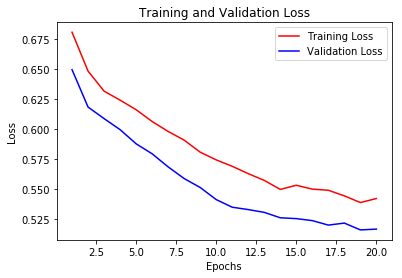

In [12]:
import matplotlib.pyplot as plt

# Plot train/val loss 
plt.clf()
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

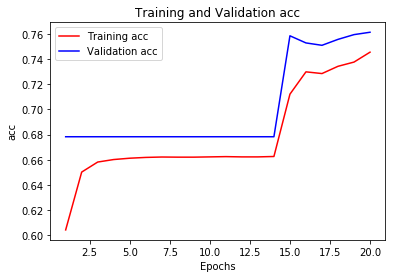

In [13]:
# Plot train/val acc
plt.clf()
history_dict = history.history
train_metric = history_dict['acc']
val_metric = history_dict['val_' + 'acc']
epochs = range(1, len(train_metric) + 1)
plt.plot(epochs, train_metric, 'r', label='Training {}'.format('acc'))
plt.plot(epochs, val_metric, 'b', label='Validation {}'.format('acc'))
plt.title('Training and Validation {}'.format('acc'))
plt.xlabel('Epochs')
plt.ylabel('{}'.format('acc'))
plt.legend()

In [14]:
y_pred = model.predict(X_test)
y_pred_binary = [0 if value[0] < 0.5 else 1 for value in y_pred]

27/03/19 15:37:47 [INFO] Initialized Classifier: Bi-LSTM Based Model
27/03/19 15:37:47 [INFO] LSTM Layers: 50
27/03/19 15:37:47 [INFO] Embedding Input Dimension: 200
27/03/19 15:37:47 [INFO] Embedding Output Dimension: 100
27/03/19 15:37:47 [INFO] MLP Layers: 16
27/03/19 15:37:47 [INFO] MLP Activation: <function relu at 0x11374b2f0>
27/03/19 15:37:47 [INFO] Dropout 1: 0.5
27/03/19 15:37:47 [INFO] Dropout 2: 0.5
27/03/19 15:37:47 [INFO] Dropout 3: 0.5
27/03/19 15:37:47 [INFO] Output Activation: <function sigmoid at 0x1137c8840>
27/03/19 15:37:47 [INFO] Epochs: range(1, 21)
27/03/19 15:37:47 [INFO] Batch Size: 512
27/03/19 15:37:47 [INFO] Optimizer: adam
27/03/19 15:37:47 [INFO] Loss Function: binary_crossentropy
27/03/19 15:37:47 [INFO] Metrics: ['accuracy']


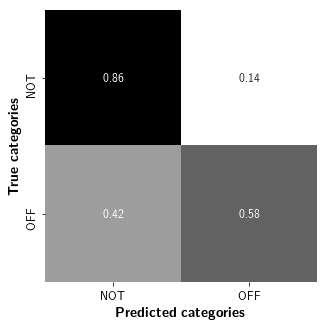

In [16]:
from src.classifiers.classifier_bi_lstm import BiLstmClassifier
classifier = BiLstmClassifier(
        embedding_input_dim=200,
        logfile=None,
        epochs=epochs,
    )

confusion_df = classifier.confusion_matrix(
        y_test, y_pred_binary, 2, ["NOT", "OFF"])

classifier.plot_confusion_matrix(
        confusion_df, file_path=None)

In [25]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2124400   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                19360     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 164       
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total para